## Identifying hits 

In this section, we analyze the generated scores from the previous step. These scores quantify the magnitudes of phenotypic differences between the "on" and "off" morphological signatures. The "on" morphological signatures represent the morphology features that are significantly affected when compared to a reference state. In contrast, the "off" morphological signatures are features that remain unaffected by both states, making them a reliable source for tracking off-target effects.

In [1]:
import pathlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Setting up helper functions

In [2]:
def update_dmso_name(treatment_name: str, cell_type: str) -> str:
    """Update the name of the treatment if it is "DMSO" based on the cell type.

    Parameters
    ----------
    treatment_name : str
        The name of the treatment.
    cell_type : str
        The type of cell, which can indicate if it is "failing" or not.

    Returns
    -------
    str
        The updated treatment name. If the treatment is "DMSO" and the cell type
        contains "failing", returns "DMSO-failing". If the treatment is "DMSO" and
        the cell type does not contain "failing", returns "DMSO-healthy". Otherwise,
        returns the original treatment name.
    """
    if treatment_name in "DMSO":
        if "failing" in cell_type:
            return "DMSO-failing"
        else:
            return "DMSO-healthy"
    else:
        return treatment_name


setting up paths

In [3]:
# setting results directory
results_dir = pathlib.Path("./results").resolve(strict=True)

# setting kl divergence score path
kl_divergence_score_path = (results_dir / "metrics/_kl_divergence_scores.csv").resolve(
    strict=True
)

# setting treated and control paths
trt_pathway_path = pathlib.Path(
    "../data/metadata/original_platemaps/pathways_platemap.csv"
).resolve(strict=True)

# create a results folder known as "hits"
hits_dir = (results_dir / "hits").resolve()
hits_dir.mkdir(exist_ok=True)

Loading in profiles and metadata

In [4]:
# loading treatment pathway data
pathway_df = pd.read_csv(trt_pathway_path)

# loading in the kl divergence scores
scores_df = pd.read_csv(kl_divergence_score_path)

print(scores_df.shape)
scores_df.head()

(440, 6)


,treatment_name,target_cluster,treated_cluster,off_kl_divergence,on_kl_divergence,combined_score
0,DMSO-failing,3,9,0.008007,0.002407,0.005207
1,DMSO-failing,3,0,0.003692,0.004034,0.003863
2,DMSO-failing,3,7,0.015903,0.010059,0.012981
3,DMSO-failing,3,5,0.004957,0.003687,0.004322
4,DMSO-failing,3,4,0.035278,0.015932,0.025605


## Finding potential hits

Here, we load the scores to identify compounds that demonstrate potential reversal effects. Using the loaded scores, we rank the compounds based first on their on-morphology scores and then on their off-morphology scores. These scores were generated using the positive control (healthy CF cells + DMSO), where smaller scores indicate a stronger potential for reversal. Specifically, lower on-morphology scores suggest that the treated cells closely resemble the positive control, while lower off-morphology scores indicate minimal off-target effects.

In [5]:
# identify_hits
scores_df = scores_df
method = "mean"
strata = ["treatment_name"]

scores = []
for strata_name, score_df in scores_df.groupby(strata):
    # if the method is 'mean', then we take the mean of both on and off scores
    if method == "mean":
        off_morph_score = score_df["off_kl_divergence"].mean()
        on_morph_score = score_df["on_kl_divergence"].mean()
        comb_morph_score = score_df["combined_score"].mean()
    # if the method is 'max', then we take the max of both on and off scores
    elif method == "max":
        off_morph_score = score_df["off_morph_score"].max()
        on_morph_score = score_df["on_morph_score"].max()
        comb_morph_score = score_df["combined_score"].max()
    # if the method is 'median', then we take the median of both on and off scores
    elif method == "median":
        off_morph_score = score_df["off_morph_score"].median()
        on_morph_score = score_df["on_morph_score"].median()
        comb_morph_score = score_df["combined_score"].median()
    else:
        raise ValueError(f"Method {method} not recognized")

    # next we save the scores into a list
    aggregated_score = [
        strata_name[0],
        off_morph_score,
        on_morph_score,
        comb_morph_score,
    ]
    scores.append(aggregated_score)

# convert scores to a dataframe
scores = pd.DataFrame(
    scores,
    columns=["treatment_name", "off_morph_score", "on_morph_score", "combined_score"],
)
ranked_df = scores.sort_values(
    by=["on_morph_score", "off_morph_score"], ascending=[False, False]
)
ranked_df = ranked_df.reset_index(drop=True)

# next we use the .rank() method to rank the scores where the lowest value is the highest rank
ranked_df["on_morph_rank"] = ranked_df["on_morph_score"].rank(ascending=False)
ranked_df["off_morph_rank"] = ranked_df["off_morph_score"].rank(ascending=False)
ranked_df["combined_morph_rank"] = ranked_df[["on_morph_rank", "off_morph_rank"]].mean(
    axis=1
)

# display
print(ranked_df.shape)
ranked_df.head()


(43, 7)


,treatment_name,off_morph_score,on_morph_score,combined_score,on_morph_rank,off_morph_rank,combined_morph_rank
0,UCD-0159286,0.030148,0.024242,0.027195,1.0,1.0,1.0
1,UCD-0159280,0.021017,0.014964,0.017991,2.0,2.0,2.0
2,UCD-0159283,0.016490,0.013515,0.015003,3.0,5.0,4.0
3,UCD-0001613,0.012695,0.013444,0.013069,4.0,17.0,10.5
4,UCD-0159275,0.016585,0.011948,0.014266,5.0,4.0,4.5


In [6]:
# Next we want to merge the pathway information with the ranked_df
# First we need to update the DMSO name based on the cell type to match with the DMSO
# label in the ranked_df
pathway_df["UCD ID"] = pathway_df.apply(
    lambda row: update_dmso_name(row["UCD ID"], row["Cell Type"]), axis=1
)

# Select only the UCD ID and Pathway columns
pathway_info_df = pathway_df[["UCD ID", "Pathway"]]

# merge the pathway info with the ranked_df
ranked_df = ranked_df.merge(
    pathway_info_df, left_on="treatment_name", right_on="UCD ID", how="left"
)

# Drop the UCD ID column
ranked_df = ranked_df.drop(columns=["UCD ID"])

# display
print(ranked_df.shape)
ranked_df.head()

(86, 8)


,treatment_name,off_morph_score,on_morph_score,combined_score,on_morph_rank,off_morph_rank,combined_morph_rank,Pathway
0,UCD-0159286,0.030148,0.024242,0.027195,1.0,1.0,1.0,Others
1,UCD-0159280,0.021017,0.014964,0.017991,2.0,2.0,2.0,Others
2,UCD-0159283,0.016490,0.013515,0.015003,3.0,5.0,4.0,Endocrinology & Hormones
3,UCD-0001613,0.012695,0.013444,0.013069,4.0,17.0,10.5,Endocrinology & Hormones
4,UCD-0159275,0.016585,0.011948,0.014266,5.0,4.0,4.5,Others


Next we rank they treatments based on their three scores

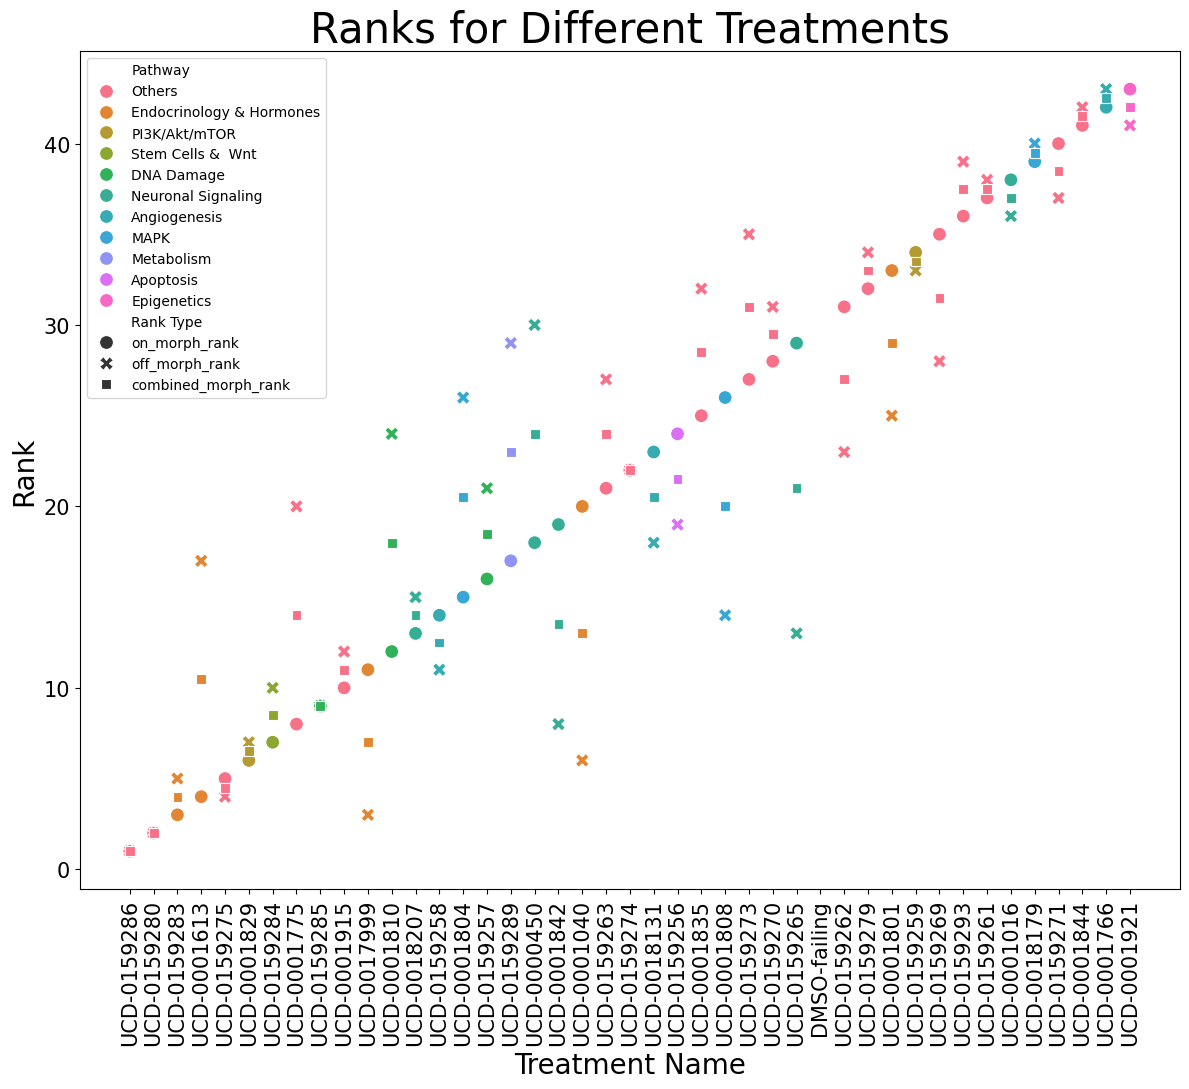

In [7]:
# Melt the DataFrame for plotting
# This transforms the DataFrame from wide format to long format
# so that we can plot the ranks for different treatments and pathways
ranked_df_melted = ranked_df.melt(
    id_vars=["treatment_name", "Pathway"],
    value_vars=["on_morph_rank", "off_morph_rank", "combined_morph_rank"],
    var_name="Rank Type",
    value_name="Rank",
)

# Plot using seaborn
# Here we are plotting the ranks for different treatments and pathways
# The x-axis is the treatment name, the y-axis is the rank, the hue is the pathway,
# and the style is the rank type
plt.figure(figsize=(12, 11))
sns.scatterplot(
    data=ranked_df_melted,
    x="treatment_name",
    y="Rank",
    hue="Pathway",
    style="Rank Type",
    s=100,
)

# Updating the axis labels and title
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)

# Adding a title, labels and legend
plt.title("Ranks for Different Treatments", fontsize=30)
plt.xlabel("Treatment Name", fontsize=20)
plt.ylabel("Rank", fontsize=20)

# adding a legend
plt.legend()

# Saving the plot
plt.tight_layout()
plt.show()